In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
os.chdir('/home/erick/Desktop/Doctorado/doctorado_efsg/pruebas')

In [3]:
def correlation_2D(step):
    #obten el módulo del promedio del espectro de potencias
    abs_c = "FFT_" + "c_" + "{:.3f}".format(step) + ".txt"
    abs_s = "FFT_" + "s_" + "{:.3f}".format(step) + ".txt"
    abs_i = "FFT_" + "i_" + "{:.3f}".format(step) + ".txt"
    
    mod_c = np.loadtxt(abs_c, float)
    mod_s = np.loadtxt(abs_s, float)
    mod_i = np.loadtxt(abs_i, float)
    
    # calcula la inversa del modulo al cuadrado
    c2_inv = np.fft.ifftn(mod_c**2)
    max_fft_c2_inv = np.where(c2_inv == c2_inv.max())
    c2_inv[max_fft_c2_inv[0][0],max_fft_c2_inv[1][0]] = 0   
    
    s2_inv = np.fft.ifftn(mod_s**2)
    max_fft_s2_inv = np.where(s2_inv == s2_inv.max())
    s2_inv[max_fft_s2_inv[0][0],max_fft_s2_inv[1][0]] = 0

    i2_inv = np.fft.ifftn(mod_i**2)
    max_fft_i2_inv = np.where(i2_inv == i2_inv.max())
    i2_inv[max_fft_i2_inv[0][0],max_fft_i2_inv[1][0]] = 0
    

    cs_inv = np.fft.ifftn(mod_c*mod_s)
    max_fft_cs_inv = np.where(cs_inv == cs_inv.max())
    cs_inv[max_fft_cs_inv[0][0],max_fft_cs_inv[1][0]] = 0
    
    ci_inv = np.fft.ifftn(mod_c*mod_i)
    max_fft_ci_inv = np.where(ci_inv == ci_inv.max())
    ci_inv[max_fft_ci_inv[0][0],max_fft_ci_inv[1][0]] = 0
    
    si_inv = np.fft.ifftn(mod_s*mod_i)
    max_fft_si_inv = np.where(si_inv == si_inv.max())
    si_inv[max_fft_si_inv[0][0],max_fft_si_inv[1][0]] = 0
 
    #Desplace el componente de frecuencia cero al centro del espectro.
    c2_inv = np.fft.fftshift(c2_inv)
    s2_inv = np.fft.fftshift(s2_inv)
    i2_inv = np.fft.fftshift(i2_inv)
    cs_inv = np.fft.fftshift(cs_inv)
    ci_inv = np.fft.fftshift(ci_inv)
    si_inv = np.fft.fftshift(si_inv)

    # Obten el valor absoluto de la tranformada inversa
    file_abs_c  = np.abs(c2_inv)
    file_abs_s  = np.abs(s2_inv)
    file_abs_i  = np.abs(i2_inv)

    file_abs_cs = np.abs(cs_inv)
    file_abs_ci = np.abs(ci_inv)
    file_abs_si = np.abs(si_inv)
 

    mean_c = np.mean(file_abs_c)
    mean_s = np.mean(file_abs_s)
    mean_i = np.mean(file_abs_i)
    
    std_c = np.std(mod_c)
    std_s =  np.std(mod_s)
    std_i =  np.std(mod_i)
    
    #Calcula las correlaciones
    corr_cc = (file_abs_c - mean_c**2) / (std_c*std_c)
    corr_ss = (file_abs_s - mean_s**2) / (std_s*std_s)
    corr_ii = (file_abs_i - mean_i**2) / (std_i*std_i)

    
    corr_cs = (file_abs_cs - mean_c*mean_s) / (std_c*std_s)
    corr_ci = (file_abs_ci - mean_c*mean_i) / (std_c*std_i)
    corr_si = (file_abs_si - mean_s*mean_i) / (std_s*std_i)

    
    matrix_corr_cc_file = "matrix_corr" + "_cc_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_cc_file, corr_cc, delimiter="\t")
    matrix_corr_ss_file = "matrix_corr" + "_ss_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_ss_file, corr_ss, delimiter="\t")
    matrix_corr_ii_file = "matrix_corr" + "_ii_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_ii_file, corr_ii, delimiter="\t")
    matrix_corr_cs_file = "matrix_corr" + "_cs_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_cs_file, corr_cs, delimiter="\t")
    matrix_corr_ci_file = "matrix_corr" + "_ci_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_ci_file, corr_ci, delimiter="\t")
    matrix_corr_si_file = "matrix_corr" + "_si_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_si_file, corr_si, delimiter="\t")

    return None

In [4]:
def polar_mean(step, corr_type):
    matrix_file = "matrix_corr_" + corr_type + "_" + "{:.3f}".format(step) + ".txt"
    matrix = np.loadtxt(matrix_file, float)
    n = len(matrix)  
    dk = 1.0
    p = np.zeros(int(n/2))
    for i in range(1,int(n/2)): 
        k = dk*i
        suma = 0.
        dtheta = np.pi/90. # two degrees

        for j in range (1,180):
            theta = j * dtheta    
            nx = int(k*np.cos(theta)/dk - n/2)
            ny = int(k*np.sin(theta)/dk - n/2)
            suma += matrix[nx,ny]        
        p[i] = suma/180.

    filename = "correlation_" + corr_type + "_" + "{:.3f}".format(step) + ".txt"         
    np.savetxt(filename, p, delimiter="\n")
    return None

In [5]:
def get_correlation(step, corr_type):
    file = "correlation_"+corr_type+"_"+"{:.3f}".format(step)+".txt"
    corr = np.loadtxt(file, float)
    # plt.figure(figsize=(10, 6))
    # plt.plot(corr, marker='o', linestyle='-', color='b')
    # plt.title('Grafica de los datos proporcionados')
    # plt.xlabel('Índice')
    # plt.ylabel('Valor')
    # plt.grid(True)
    # plt.show()
    return corr

In [6]:
def plot_correlations_3d(corr_type, time_steps):
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    # plot a 3D surface like in the example mplot3d/surface3d_demo
    X = np.arange(0, 15, 1)
    Y = np.arange(0.001, time_steps, 0.001)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([get_correlation(i, corr_type) for i in np.arange(0.001, time_steps, 0.001)])

    surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=1, alpha=1, cmap='Reds', linewidth=0.3, edgecolors='black')
    fig.colorbar(surf, shrink=0.3, aspect=8, location='left', ax=ax)

    ax.view_init(15, 55)
#    ax.set_zlim(bottom=0)
    ax.set_xlim(0,20)
    ax.set_ylim(0,time_steps)

    ax.set_xlabel('Number wave "r"', fontsize=15)
    ax.set_ylabel('Time step', fontsize=15)
    ax.set_zlabel('P(k,t)', fontsize=15)
    #plt.savefig("correlations_3D_{}.png".format(corr_type))
    return plt.show()

In [7]:
def plot_contour(corr_type, time_steps):
    fig, ax = plt.subplots(figsize=(12,6))

    # plot a 3D surface like in the example mplot3d/surface3d_demo
    Y = np.arange(0.001, time_steps, 0.001)
    X = np.arange(0, 15, 1)
    X,Y  = np.meshgrid(X, Y)
    Z = np.array([get_correlation(i, corr_type) for i in np.arange(0.001, time_steps, 0.001)])
    
    CS = ax.contour(X, Y, Z, levels = [0.25, 0.5, 0.75])
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Correlation length' + ' ' + corr_type)
    
    #ax.set_ylim(0,20)
    plt.savefig("correlations_length_{}.png".format(corr_type))
    return plt.show()

In [8]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))

In [9]:
t = 0.001
while t < T:
    correlation_2D(t)
    t += dt

In [10]:
t = 0.001
while t < T:
    polar_mean(t, "cc")
    t += dt

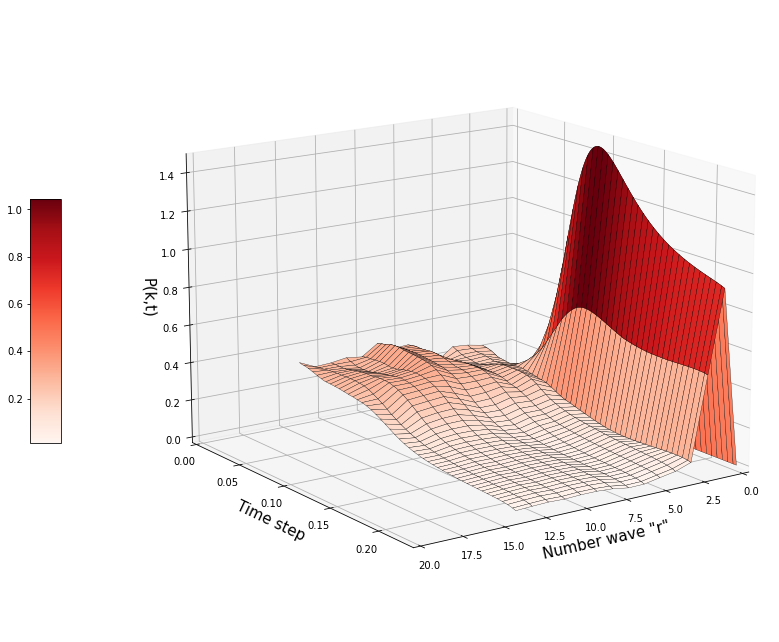

In [11]:
plot_correlations_3d('cc', T)

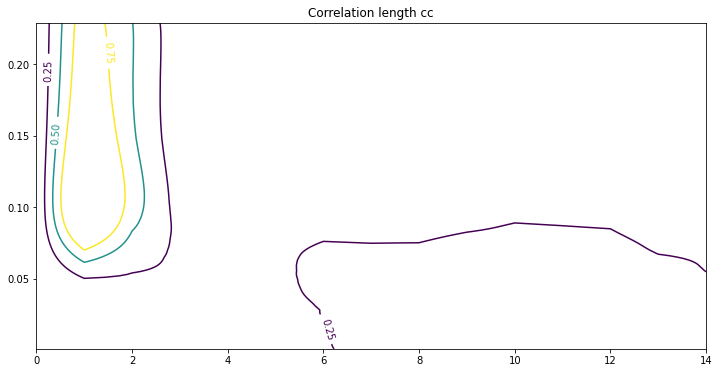

In [12]:
plot_contour('cc', T)

In [13]:
t = 0.001
while t < T:
    polar_mean(t, "ss")
    t += dt

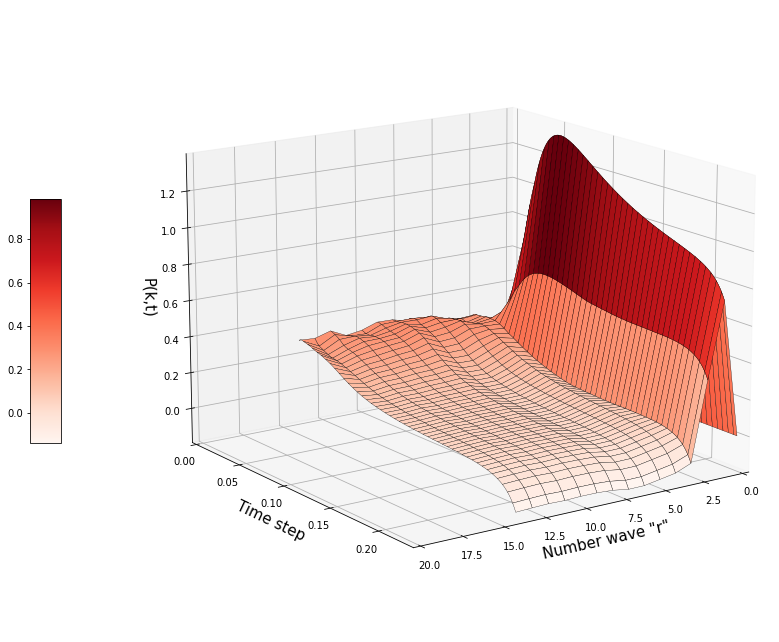

In [14]:
plot_correlations_3d('ss', T)

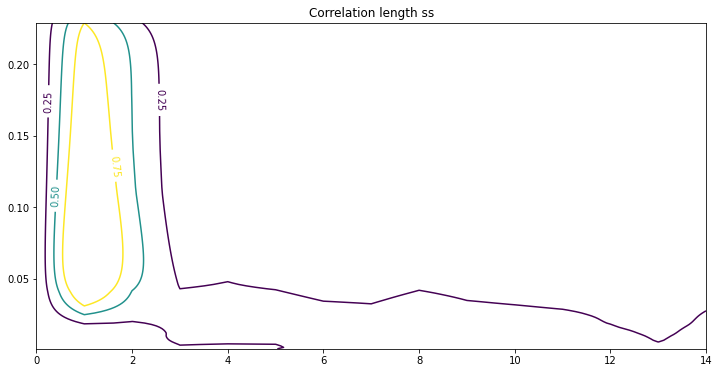

In [15]:
plot_contour('ss', T)

In [16]:
t = 0.001
while t < T:
    polar_mean(t, "ii")
    t += dt

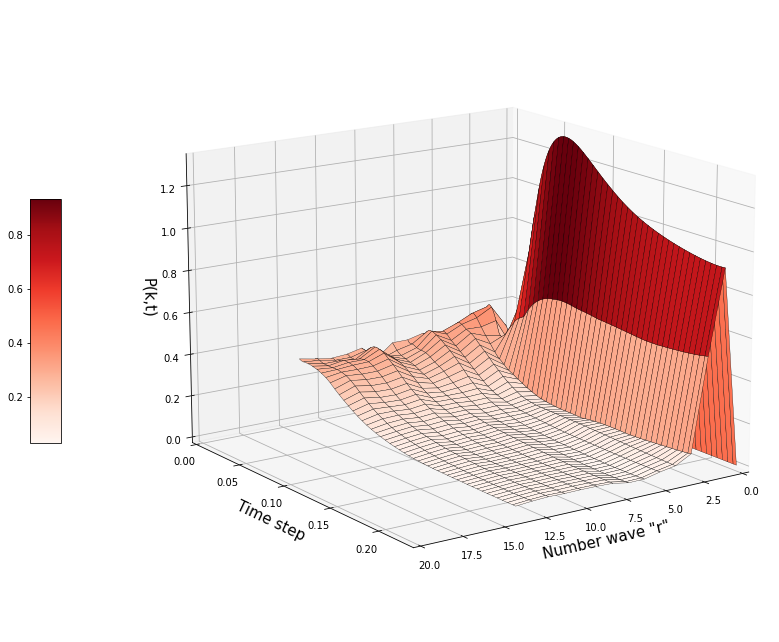

In [17]:
plot_correlations_3d('ii', T)

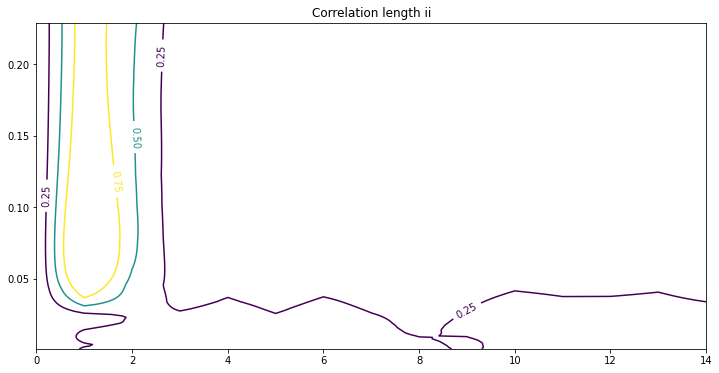

In [18]:
plot_contour('ii', T)

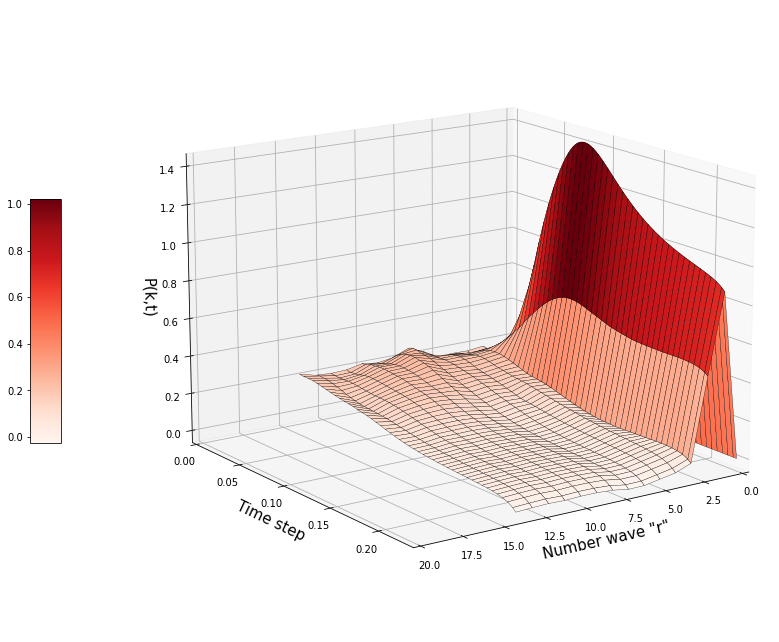

In [19]:
t = 0.001
while t < T:
    polar_mean(t, "cs")
    t += dt
plot_correlations_3d('cs', T)

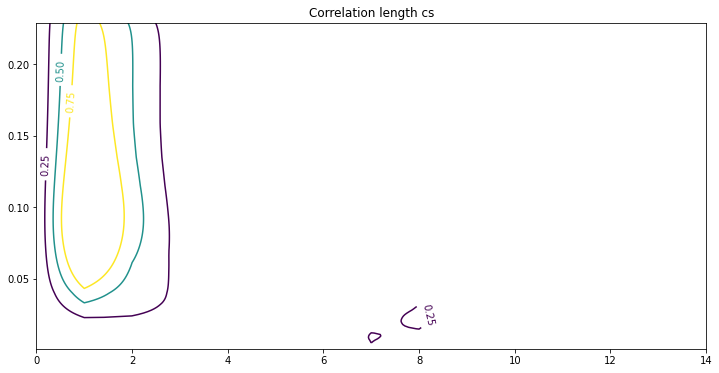

In [20]:
plot_contour('cs', T)

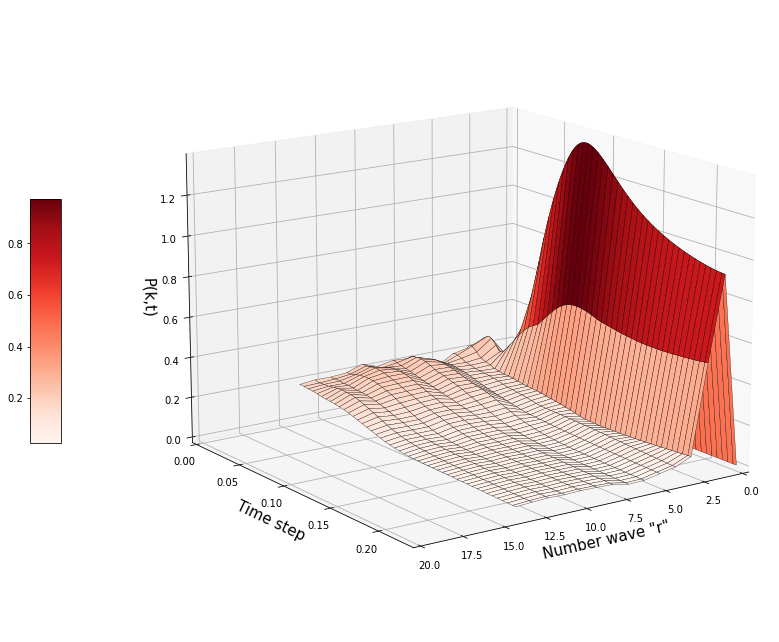

In [21]:
t = 0.001
while t < T:
    polar_mean(t, "ci")
    t += dt
plot_correlations_3d('ci', T)

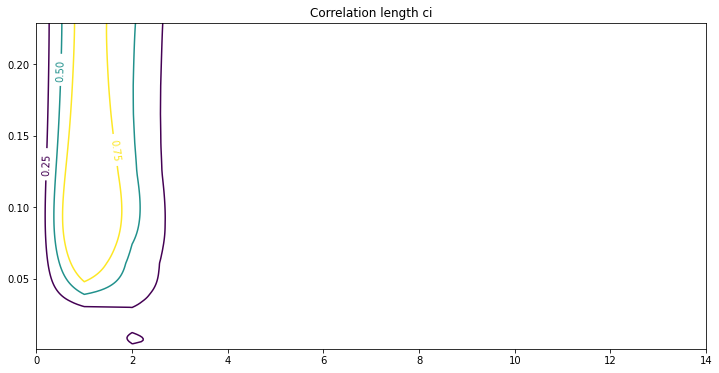

In [22]:
plot_contour('ci', T)

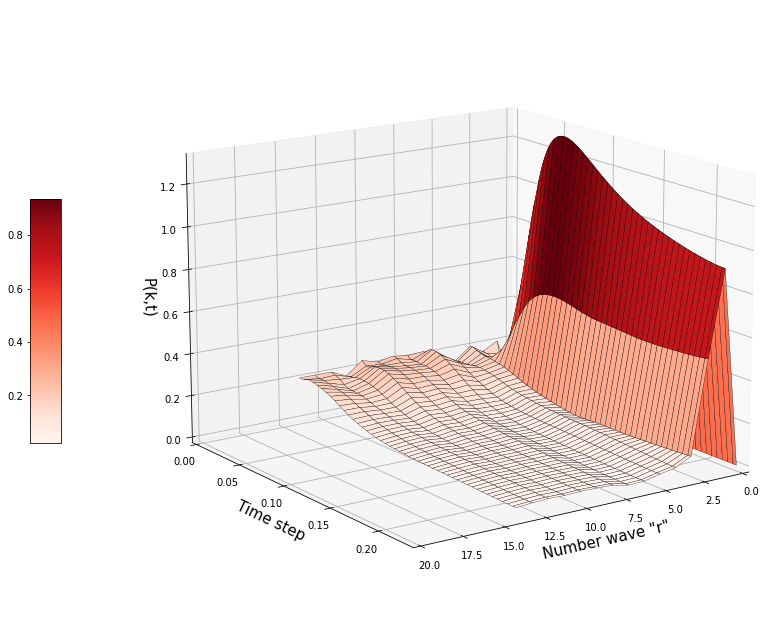

In [23]:
t = 0.001
while t < T:
    polar_mean(t, "si")
    t += dt
plot_correlations_3d('si', T)

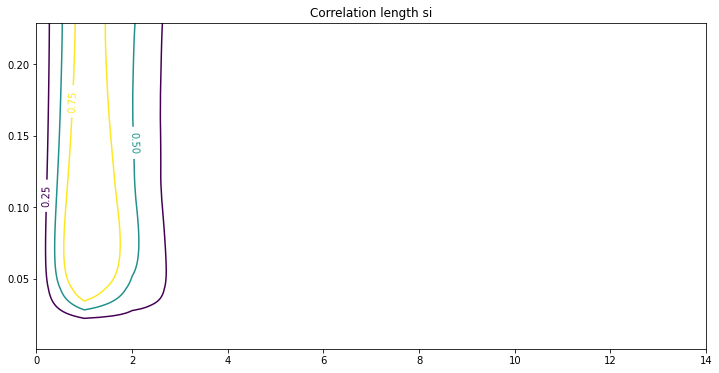

In [24]:
plot_contour('si', T)